In [ ]:
# Cell 1 : Environment Setup & Dependency Cleanup

!apt-get remove --purge -y sumo sumo-tools sumo-doc -qq
!apt-get autoremove -y -qq
!apt-get clean

!pip uninstall -y traci gymnasium numpy matplotlib stable-baselines3 protobuf tensorboard tb-nightly

!apt-get update -qq
!apt-get install -y sumo sumo-tools sumo-doc -qq

!pip install traci gymnasium numpy matplotlib stable-baselines3[extra] protobuf==3.20 tensorboard==2.12.3 > /dev/null

import traci
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import matplotlib.pyplot as plt

print("SUMO + Python packages + TensorBoard fix applied and ready!")


(Reading database ... 128952 files and directories currently installed.)
Removing sumo (1.12.0+dfsg1-1) ...
Removing sumo-doc (1.12.0+dfsg1-1) ...
Removing sumo-tools (1.12.0+dfsg1-1) ...
Processing triggers for mailcap (3.70+nmu1ubuntu1) ...
Processing triggers for man-db (2.10.2-1) ...
(Reading database ... 126547 files and directories currently installed.)
Purging configuration files for sumo (1.12.0+dfsg1-1) ...
(Reading database ... 126545 files and directories currently installed.)
Removing jarwrapper (0.78) ...
Removing binfmt-support (2.2.1-2) ...
invoke-rc.d: could not determine current runlevel
invoke-rc.d: policy-rc.d denied execution of stop.
Removing fastjar (2:0.98-7) ...
Removing fonts-roboto-unhinted (2:0~20170802-3) ...
dpkg: warning: while removing fonts-roboto-unhinted, directory '/usr/share/fonts/truetype/roboto/unhinted/RobotoTTF' not empty so not removed
Removing libopenscenegraph161:amd64 (3.6.5+dfsg1-7build5) ...
Removing libcoin80c (4.0.0+ds-2) ...
Removing lib

# Custom Traffic Network Creation for RL

This step builds a 4-way intersection SUMO network that serves as the simulation playground for training RL agents. It includes:

    - Nodes & Edges: Defines center junction with N/S/E/W in-out roads.
    - Vehicle Routes & Flows: Creates four directional flows (900 veh/hr)
      simulating realistic traffic.
    - SUMO Config File: Specifies simulation start/end and links all components.
    - Net Conversion: Converts XML files into SUMO-compatible .net.xml.

This compact, intersection-based environment enables efficient and focused RL experimentation for traffic signal control.

In [ ]:
import os
os.makedirs("rl_traffic_env", exist_ok=True)

with open("rl_traffic_env/nodes.nod.xml", "w") as f:
    f.write("""<nodes>
    <node id="center" x="0.0" y="0.0" type="traffic_light"/>
    <node id="n_in" x="0.0" y="500.0" type="priority"/>
    <node id="n_out" x="0.0" y="600.0" type="priority"/>
    <node id="s_in" x="0.0" y="-500.0" type="priority"/>
    <node id="s_out" x="0.0" y="-600.0" type="priority"/>
    <node id="e_in" x="500.0" y="0.0" type="priority"/>
    <node id="e_out" x="600.0" y="0.0" type="priority"/>
    <node id="w_in" x="-500.0" y="0.0" type="priority"/>
    <node id="w_out" x="-600.0" y="0.0" type="priority"/>
</nodes>""")

with open("rl_traffic_env/edges.edg.xml", "w") as f:
    f.write("""<edges>
    <edge id="n" from="n_in" to="center"/>
    <edge id="n_out" from="center" to="n_out"/>
    <edge id="s" from="s_in" to="center"/>
    <edge id="s_out" from="center" to="s_out"/>
    <edge id="e" from="e_in" to="center"/>
    <edge id="e_out" from="center" to="e_out"/>
    <edge id="w" from="w_in" to="center"/>
    <edge id="w_out" from="center" to="w_out"/>
</edges>""")

with open("rl_traffic_env/routes.rou.xml", "w") as f:
    f.write("""<routes>
    <vType id="car" accel="0.8" decel="4.5" sigma="0.5" length="5" minGap="2.5" maxSpeed="13.9" guiShape="passenger"/>

    <route id="north_south" edges="n s_out"/>
    <route id="south_north" edges="s n_out"/>
    <route id="east_west" edges="e w_out"/>
    <route id="west_east" edges="w e_out"/>

    <flow id="flow_n_s" type="car" route="north_south" begin="0" end="1000" vehsPerHour="900"/>
    <flow id="flow_s_n" type="car" route="south_north" begin="0" end="1000" vehsPerHour="900"/>
    <flow id="flow_e_w" type="car" route="east_west" begin="0" end="1000" vehsPerHour="900"/>
    <flow id="flow_w_e" type="car" route="west_east" begin="0" end="1000" vehsPerHour="900"/>
</routes>""")

with open("rl_traffic_env/sumo_config.sumocfg", "w") as f:
    f.write("""<configuration>
    <input>
        <net-file value="network.net.xml"/>
        <route-files value="routes.rou.xml"/>
    </input>
    <time>
        <begin value="0"/>
        <end value="1000"/>
    </time>
</configuration>""")

!netconvert -n rl_traffic_env/nodes.nod.xml -e rl_traffic_env/edges.edg.xml -o rl_traffic_env/network.net.xml

print("SUMO network setup complete!")


Success.
✅ SUMO network setup complete!


# Custom SUMO Gym Environment (SumoTrafficGymEnv)

This cell defines a custom OpenAI Gym-compatible environment to integrate SUMO with reinforcement learning agents. Key features:

    - Action Space: 4 discrete traffic light phases (e.g., N→S, S→N, etc.).
    - Observation Space: Vehicle counts from 4 directions as state input.
    - Reward Function: Encourages reduced waiting time (Δ queue length).
    - Lifecycle Methods: Implements reset, step, and close for clean RL
      interaction.

This modular class bridges SUMO traffic simulation with Gym RL agents, enabling seamless training and evaluation.

In [ ]:
import gc
from gymnasium import Env, spaces
import numpy as np
import traci

class SumoTrafficGymEnv(Env):
    def __init__(self, sumo_cfg_path="rl_traffic_env/sumo_config.sumocfg", max_steps=100):
        self.sumo_cfg_path = sumo_cfg_path
        self.max_steps = max_steps
        self.current_step = 0
        self.tl_id = "center"

        self.action_space = spaces.Discrete(4)
        self.observation_space = spaces.Box(low=0, high=100, shape=(4,), dtype=np.float32)

        self.prev_wait = 0

    def reset(self, seed=None, options=None):
        if traci.isLoaded():
            traci.close()
        traci.start(["sumo", "-c", self.sumo_cfg_path, "--start", "--no-warnings"], label="sim")
        self.current_step = 0
        self.prev_wait = sum(traci.edge.getLastStepHaltingNumber(l) for l in ["n", "s", "e", "w"])
        return self._get_state(), {}

    def step(self, action):
        action = int(action)
        traci.trafficlight.setPhase(self.tl_id, action)
        traci.simulationStep()
        self.current_step += 1

        state = self._get_state()
        current_wait = sum(traci.edge.getLastStepHaltingNumber(l) for l in ["n", "s", "e", "w"])
        reward = self.prev_wait - current_wait
        self.prev_wait = current_wait

        done = self.current_step >= self.max_steps
        return state, reward, done, False, {}

    def _get_state(self):
        return np.array([traci.edge.getLastStepVehicleNumber(l) for l in ["n", "s", "e", "w"]], dtype=np.float32)

    def close(self):
        if traci.isLoaded():
            traci.close()
        gc.collect()


# Environment Sanity Check with Manual Actions

This cell runs a quick 20-step simulation loop using a round-robin pattern of actions (N→S, S→N, etc.) to validate the environment:

    - State: Vehicle counts from all directions at each step.
    - Reward: Difference in total halting vehicles before and after the action.
    - Result: Structured DataFrame logging step-wise behavior for debugging and
      inspection.

This confirms that the SumoTrafficGymEnv operates correctly and returns meaningful state-reward transitions.

In [ ]:
import pandas as pd
from IPython.display import display

if traci.isLoaded():
    traci.close()

env = SumoTrafficGymEnv(max_steps=20)
state, _ = env.reset()
data = []

action_names = ["N→S", "S→N", "E→W", "W→E"]

for step in range(20):
    action = step % 4
    next_state, reward, done, _, _ = env.step(action)
    data.append({
        "Step": step + 1,
        "Action": action_names[action],
        "State": list(next_state.astype(int)),
        "Reward": reward
    })
    if done:
        break

env.close()
del env; gc.collect()

df = pd.DataFrame(data)
display(df)


 Retrying in 1 seconds


,Step,Action,State,Reward
0,1,N→S,"[1, 1, 1, 1]",-4
1,2,S→N,"[1, 1, 1, 1]",4
2,3,E→W,"[1, 1, 1, 1]",0
3,4,W→E,"[1, 1, 1, 1]",0
4,5,N→S,"[1, 1, 1, 1]",0
5,6,S→N,"[2, 2, 2, 2]",-4
6,7,E→W,"[2, 2, 2, 2]",4
7,8,W→E,"[2, 2, 2, 2]",0
8,9,N→S,"[2, 2, 2, 2]",0
9,10,S→N,"[2, 2, 2, 2]",0


# DQN Agent Training for Smart Traffic Control

This cell trains a Deep Q-Network (DQN) agent using the custom SumoTrafficGymEnv:

    - Environment Validated using check_env().
    - Training Specs:
         i.   20,000 timesteps
         ii.  High exploration (eps=1.0 → 0.05)
         iii. MlpPolicy for dense observations
    - Model Saved as "dqn_traffic_controller" for later evaluation.

This DQN agent learns optimal phase switching to minimize traffic queue buildup at a 4-way signal.

In [ ]:
from stable_baselines3 import DQN
from stable_baselines3.common.env_checker import check_env

env = SumoTrafficGymEnv(max_steps=100)
check_env(env)

model = DQN(
    "MlpPolicy",
    env,
    verbose=1,
    seed = 1,
    exploration_fraction=0.5,
    exploration_initial_eps=1.0,
    exploration_final_eps=0.05
)

model.learn(total_timesteps=20000)
model.save("dqn_traffic_controller")

env.close()
del env; gc.collect()

print("Training complete. Model saved!")


 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 100      |
|    ep_rew_mean      | -11      |
|    exploration_rate | 0.962    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 70       |
|    time_elapsed     | 5        |
|    total_timesteps  | 400      |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.778    |
|    n_updates        | 74       |
----------------------------------
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 100      |

# DQN Agent Evaluation on SUMO Traffic Environment

This cell runs a 100-step simulation using the trained DQN model on the custom traffic environment:

    - Deterministic Decisions: Agent chooses best action without randomness.
    - Step-by-Step Logging: Captures phase, vehicle state, and reward per step.
    - Total Reward Achieved: Final reward score quantifies how effectively the
      agent reduced congestion.

Resulting DataFrame reveals how well the agent optimized signal phases to manage traffic flow.

In [ ]:
import pandas as pd

model = DQN.load("dqn_traffic_controller")
env = SumoTrafficGymEnv(max_steps=100)

obs, _ = env.reset()
done = False
data, step_count, total_reward = [], 0, 0

action_map = {
    0: "N→S",
    1: "S→N",
    2: "E→W",
    3: "W→E"
}

while not done:
    action, _ = model.predict(obs, deterministic=True)
    action = int(action)
    obs, reward, done, _, _ = env.step(action)
    step_count += 1
    total_reward += reward
    data.append({
        "Step": step_count,
        "Action": action_map[action],
        "State": list(obs.astype(int)),
        "Reward": reward
    })

env.close()
del env; gc.collect()

df = pd.DataFrame(data)

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

display(df)
print(f"Total Reward: {total_reward}")


 Retrying in 1 seconds


,Step,Action,State,Reward
0,1,S→N,"[1, 1, 1, 1]",-4
1,2,W→E,"[1, 1, 1, 1]",4
2,3,W→E,"[1, 1, 1, 1]",0
3,4,W→E,"[1, 1, 1, 1]",0
4,5,W→E,"[1, 1, 1, 1]",0
5,6,W→E,"[2, 2, 2, 2]",-4
6,7,W→E,"[2, 2, 2, 2]",4
7,8,W→E,"[2, 2, 2, 2]",0
8,9,W→E,"[2, 2, 2, 2]",0
9,10,W→E,"[2, 2, 2, 2]",0


📊 Total Reward: -19


# DQN-Controlled Traffic Simulation with Directional State Logging

This cell enhances evaluation by logging vehicle counts at each direction (N, S, E, W) along with rewards at every step:

    - Action-Effect Insight: Each DQN decision is mapped to directional traffic
      states.
    - Granular Visibility: Captures impact of light phase selection on all
      lanes.
    - DataFrame Output: Useful for heatmap visualizations and traffic behavior
      analysis.

Offers a clear, interpretable view of how signal choices dynamically influence lane-specific congestion.

In [ ]:
from stable_baselines3 import DQN
import pandas as pd

model = DQN.load("dqn_traffic_controller")
env = SumoTrafficGymEnv(max_steps=100)

obs, _ = env.reset()
done = False
data, step_count = [], 0

action_map = {
    0: "N→S",
    1: "S→N",
    2: "E→W",
    3: "W→E"
}

while not done:
    action, _ = model.predict(obs, deterministic=True)
    action = int(action)
    obs, reward, done, _, _ = env.step(action)
    n, s, e, w = obs.astype(int)

    data.append({
        "Step": step_count + 1,
        "Action": action_map[action],
        "N": n,
        "S": s,
        "E": e,
        "W": w,
        "Reward": reward
    })

    step_count += 1

env.close()
del env; gc.collect()

df = pd.DataFrame(data)
display(df)


 Retrying in 1 seconds


,Step,Action,N,S,E,W,Reward
0,1,S→N,1,1,1,1,-4
1,2,W→E,1,1,1,1,4
2,3,W→E,1,1,1,1,0
3,4,W→E,1,1,1,1,0
4,5,W→E,1,1,1,1,0
5,6,W→E,2,2,2,2,-4
6,7,W→E,2,2,2,2,4
7,8,W→E,2,2,2,2,0
8,9,W→E,2,2,2,2,0
9,10,W→E,2,2,2,2,0


# Multi-Agent Training & Testing Framework for SmartSignalAI

    - Unified Setup: Uses DummyVecEnv to vectorize the SumoTrafficGymEnv for
      stable-baselines3 compatibility.
    - Train Function: Accepts RL algorithm class (DQN, PPO, A2C), trains for 20,
      000 steps, saves the model with custom names.
    - Test Function: Runs multiple test episodes per trained model, reporting
      cumulative rewards for each episode.
    - Resource Handling: Ensures proper environment cleanup and garbage
      collection to prevent memory leaks.

This modular code structure enables easy comparative training and evaluation of multiple RL algorithms on traffic control simulation.


In [ ]:
from stable_baselines3 import DQN, PPO, A2C
from stable_baselines3.common.vec_env import DummyVecEnv
import gc

def make_env():
    return SumoTrafficGymEnv("rl_traffic_env/sumo_config.sumocfg", max_steps=100)

def train_agent(model_class, env_fn, model_name, total_timesteps=20000, seed=None):
    vec_env = DummyVecEnv([env_fn])
    model = model_class("MlpPolicy", vec_env, verbose=1, seed=seed)
    model.learn(total_timesteps=total_timesteps)
    model.save(f"{model_name}_model")
    vec_env.close()
    print(f"{model_name} model saved!")
    return model

def test_agent(model, env_fn, episodes=3):
    for ep in range(episodes):
        env = env_fn()
        obs, _ = env.reset()
        done, total_reward = False, 0
        while not done:
            action, _ = model.predict(obs)
            action = int(action)
            obs, reward, done, _, _ = env.step(action)
            total_reward += reward
        env.close()
        del env; gc.collect()
        print(f"Episode {ep+1} reward: {total_reward:.2f}")


# Training and Evaluation of DQN, PPO, and A2C Agents on SmartSignalAI

1. Sequential Training: Trains DQN (seed=1), PPO (seed=34), and A2C (seed=72) agents individually for 20,000 timesteps each using the common SUMO traffic environment.

2. Performance Testing: Each trained agent is tested for 3 episodes to evaluate cumulative rewards and effectiveness in managing traffic signals.

3. Reproducibility: Specific seeds set per agent ensure consistent training results for fair comparison.

4. Outcome: Enables direct benchmarking of RL algorithms’ ability to optimize urban traffic flow via learned traffic light control policies.

In [ ]:
dqn_model = train_agent(DQN, make_env, "DQN", seed=1)
test_agent(dqn_model, make_env)

ppo_model = train_agent(PPO, make_env, "PPO", seed=34)
test_agent(ppo_model, make_env)

a2c_model = train_agent(A2C, make_env, "A2C", seed=72)
test_agent(a2c_model, make_env)


Using cuda device
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.81     |
| time/               |          |
|    episodes         | 4        |
|    fps              | 70       |
|    time_elapsed     | 5        |
|    total_timesteps  | 400      |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.765    |
|    n_updates        | 74       |
----------------------------------
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.62     |
| time/               |          |
|    episodes         | 8        |
|    fps              | 76       |
|    time_elapsed     | 10       |
|    total_timesteps  | 800      |
| train/              |          |
|    

/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
-----------------------------
| time/              |      |
|    fps             | 78   |
|    iterations      | 1    |
|    time_elapsed    | 26   |
|    total_timesteps | 2048 |
-----------------------------
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retryin

/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run A2C on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
------------------------------------
| time/                 |          |
|    fps                | 63       |
|    iterations         | 100      |
|    time_elapsed       | 7        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -1.14    |
|    explained_variance | 0.00763  |
|    learning_rate      | 0.0007   |
|    n_updates          | 99       |
|    policy_loss        | -2.05    |
|    value_loss         | 7.3      |
------------------------------------
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
------------------------------------
| time/                 |          |
|    fps                | 67       |
|    iterations         | 200      |
|    time_elapsed       | 14       |
|    total_timesteps    | 1000     |
| train/                |     

# Reward Comparison of DQN, PPO, and A2C Agents on SmartSignalAI

1. Multiple Evaluations: Each RL agent (DQN, PPO, A2C) is tested across 5 episodes to capture reward consistency and variability.

2. Reward Tracking: Total rewards per episode recorded to quantitatively assess traffic signal control performance.

3. Visual Analysis: Plotted reward trends highlight comparative effectiveness, stability, and learning robustness of each agent.

4. Insight: Enables data-driven selection of the best RL approach for dynamic traffic optimization under the SmartSignalAI framework.









 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds


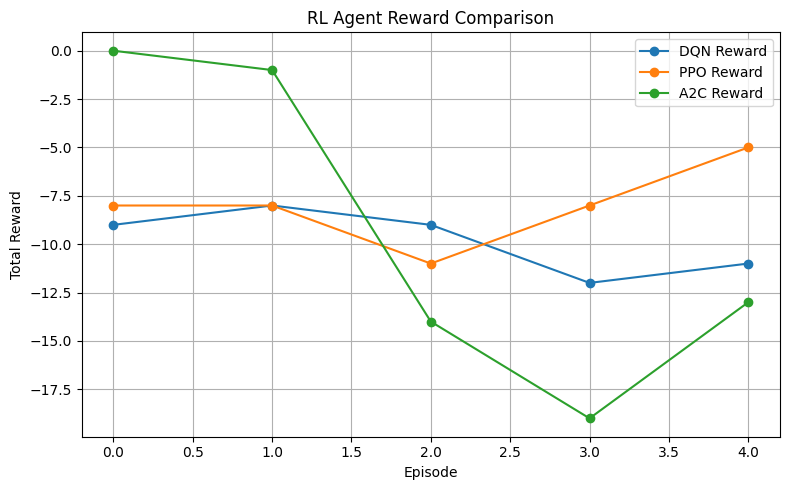

In [ ]:
agent_rewards = {
    "DQN": [],
    "PPO": [],
    "A2C": []
}

for name, model in [("DQN", dqn_model), ("PPO", ppo_model), ("A2C", a2c_model)]:
    for _ in range(5):
        env = make_env()
        obs, _ = env.reset()
        done, total_reward = False, 0
        while not done:
            action, _ = model.predict(obs)
            obs, reward, done, _, _ = env.step(action)
            total_reward += reward
        agent_rewards[name].append(total_reward)
        env.close()
        del env; gc.collect()

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
for agent, rewards in agent_rewards.items():
    plt.plot(rewards, marker="o", label=f"{agent} Reward")

plt.title("RL Agent Reward Comparison")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Visualization of DQN Agent Performance in SmartSignalAI

1. Step-wise Reward Plot: Displays immediate reward at each simulation step, showing how the agent’s decisions impact traffic flow dynamically.

2. Cumulative Reward Trend: Illustrates total accumulated reward over all steps, highlighting overall learning progress and traffic optimization effectiveness.

3. Action Distribution Chart: Counts how often each traffic phase (N→S, S→N, E→W, W→E) is selected by the DQN agent, revealing policy preferences and decision patterns.

4. Insight: These plots provide clear, intuitive insights into agent behavior and learning success during traffic signal control.

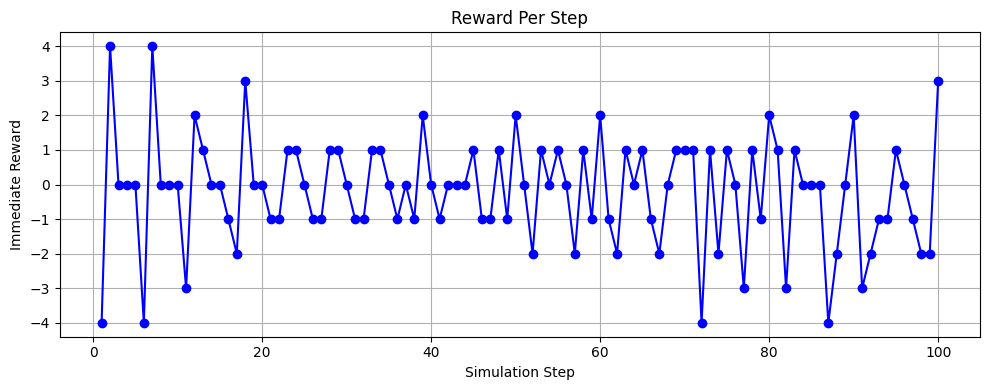

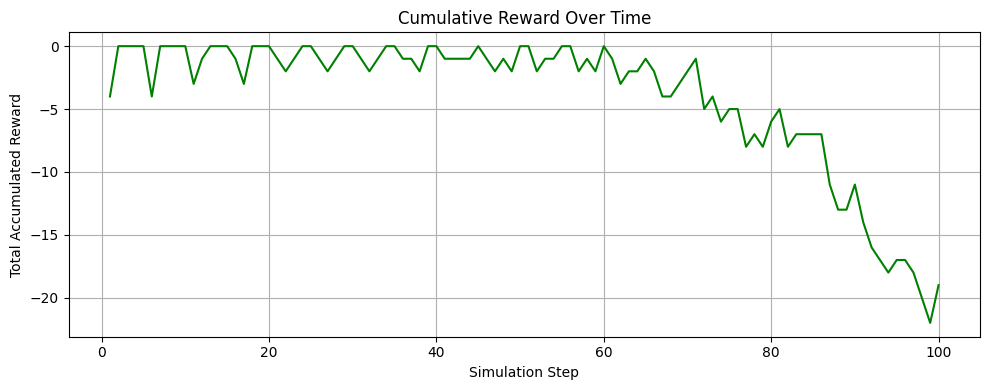

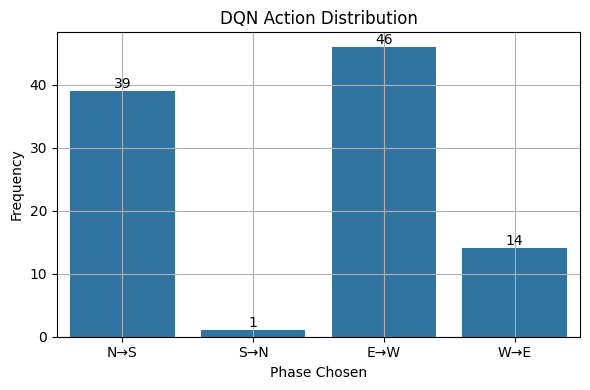

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

action_encoding = {
    "N→S": 0,
    "S→N": 1,
    "E→W": 2,
    "W→E": 3
}
df["ActionVal"] = df["Action"].map(action_encoding) # Use df["Phase"].map(action_encoding) incase of error

plt.figure(figsize=(10, 4))
plt.plot(df["Step"], df["Reward"], marker="o", linestyle="-", color="blue")
plt.title("Reward Per Step")
plt.xlabel("Simulation Step")
plt.ylabel("Immediate Reward")
plt.grid(True)
plt.tight_layout()
plt.show()

df["CumulativeReward"] = df["Reward"].cumsum()
plt.figure(figsize=(10, 4))
plt.plot(df["Step"], df["CumulativeReward"], color="green")
plt.title("Cumulative Reward Over Time")
plt.xlabel("Simulation Step")
plt.ylabel("Total Accumulated Reward")
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
ax = sns.countplot(x="ActionVal", data=df)
plt.xticks([0, 1, 2, 3], ["N→S", "S→N", "E→W", "W→E"])
plt.title("DQN Action Distribution")
plt.xlabel("Phase Chosen")
plt.ylabel("Frequency")
plt.grid(True)

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height + 0.5,
            f'{int(height)}', ha="center", fontsize=10)

plt.tight_layout()
plt.show()


# Multi-Agent Evaluation and Visualization Pipeline

- Defines test_agent_return_df() to log per-step rewards and traffic phase info from a trained RL agent.

- Handles compatibility with both 4-return and 5-return formats of env.step().

- Extracts total queued vehicles from info if available.

- Converts action index to human-readable traffic phase using action_map.

- Runs test_agent_return_df() for DQN, PPO, and A2C agents on fresh SUMO envs.

- Prints shapes and previews of resulting DataFrames for each agent.

- Adds "Agent" column to identify source in merged DataFrame.

- Ensures numeric dtype for Step and Reward columns across all agents.

- Computes "CumulativeReward" for each agent’s episode.

- Merges all agent DataFrames into one (df_all) for unified analysis.

- Displays per-agent reward statistics using groupby.describe().

- Plots cumulative reward over steps with hue as agent type.

- Plots per-step rewards to compare reward volatility.

- Plots action/phase frequency for each agent to analyze learned behavior.


 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
DQN shape: (100, 4)
   Step Phase  Vehicles  Reward
0     0   S→N       NaN      -4
1     1   W→E       NaN       4
2     2   W→E       NaN       0
3     3   W→E       NaN       0
4     4   W→E       NaN       0
PPO shape: (100, 4)
   Step Phase  Vehicles  Reward
0     0   E→W       NaN      -4
1     1   E→W       NaN       4
2     2   E→W       NaN       0
3     3   E→W       NaN       0
4     4   E→W       NaN       0
A2C shape: (100, 4)
   Step Phase  Vehicles  Reward
0     0   N→S       NaN      -4
1     1   N→S       NaN       4
2     2   N→S       NaN       0
3     3   N→S       NaN       0
4     4   N→S       NaN       0
Merged DF shape: (300, 6)
       count  mean       std  min  25%  50%  75%  max
Agent                                                
A2C    100.0 -0.17  1.531191 -4.0 -1.0  0.0  1.0  4.0
DQN    100.0 -0.09  1.518206 -4.0 -1.0  0.0  1.0  4.0
PPO    100.0 -0.05  1.629123 -4.0 -1.0  0.0  1.0  4.0

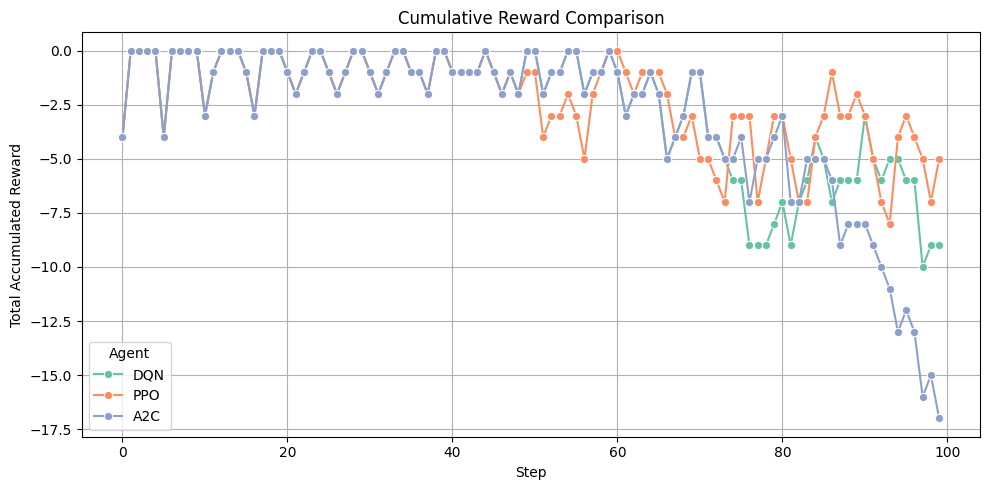

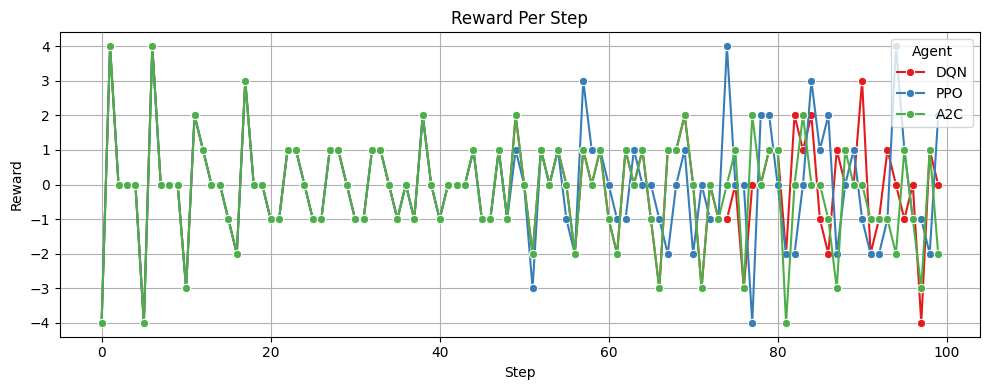

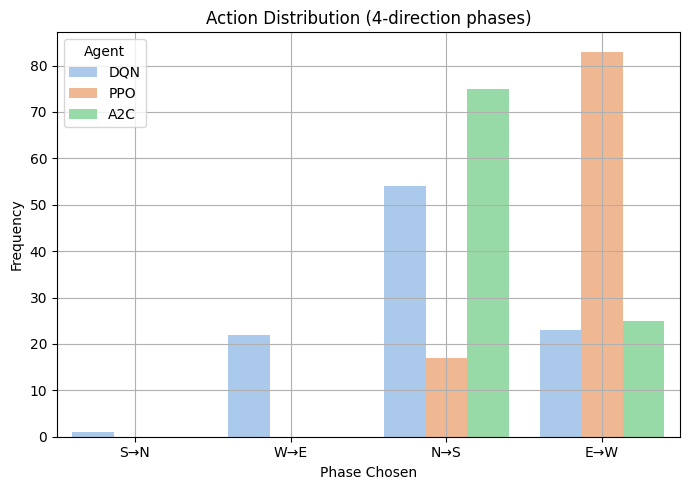

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def test_agent_return_df(model, env, max_steps=500):
    obs, info = env.reset()
    done = False
    step = 0
    records = []

    action_map = {
        0: "N→S",
        1: "S→N",
        2: "E→W",
        3: "W→E"
    }

    while not done and step < max_steps:
        action, _ = model.predict(obs, deterministic=True)

        step_result = env.step(action)
        if len(step_result) == 4:
            obs, reward, done, info = step_result
        elif len(step_result) == 5:
            obs, reward, done, truncated, info = step_result
            done = done or truncated
        else:
            raise ValueError(f"Unexpected env.step() return length: {len(step_result)}")

        if isinstance(info, (list, tuple)) and len(info) > 0:
            info = info[0]

        if isinstance(info, dict):
            total_queued = info.get("total_queued", float('nan'))
        else:
            total_queued = float('nan')

        if isinstance(action, np.ndarray):
            phase_int = action.item() if action.ndim == 0 else action[0]
        elif isinstance(action, (list, tuple)):
            phase_int = action[0]
        else:
            phase_int = action

        phase_str = action_map.get(phase_int, str(phase_int))

        records.append({
            "Step": step,
            "Phase": phase_str,
            "Vehicles": total_queued,
            "Reward": reward,
        })

        step += 1

    return pd.DataFrame(records)


env_dqn = make_env()
env_ppo = make_env()
env_a2c = make_env()

df_dqn = test_agent_return_df(dqn_model, env_dqn)
df_ppo = test_agent_return_df(ppo_model, env_ppo)
df_a2c = test_agent_return_df(a2c_model, env_a2c)

print("DQN shape:", df_dqn.shape)
print(df_dqn.head())
print("PPO shape:", df_ppo.shape)
print(df_ppo.head())
print("A2C shape:", df_a2c.shape)
print(df_a2c.head())

df_dqn["Agent"] = "DQN"
df_ppo["Agent"] = "PPO"
df_a2c["Agent"] = "A2C"

for df in [df_dqn, df_ppo, df_a2c]:
    df["Reward"] = pd.to_numeric(df["Reward"], errors='coerce')
    df["Step"] = pd.to_numeric(df["Step"], errors='coerce')

df_dqn["CumulativeReward"] = df_dqn["Reward"].cumsum()
df_ppo["CumulativeReward"] = df_ppo["Reward"].cumsum()
df_a2c["CumulativeReward"] = df_a2c["Reward"].cumsum()

df_all = pd.concat([df_dqn, df_ppo, df_a2c], ignore_index=True)

print("Merged DF shape:", df_all.shape)
print(df_all.groupby("Agent")["Reward"].describe())

plt.figure(figsize=(10, 5))
sns.lineplot(data=df_all, x="Step", y="CumulativeReward", hue="Agent", palette="Set2", marker="o")
plt.title("Cumulative Reward Comparison")
plt.xlabel("Step")
plt.ylabel("Total Accumulated Reward")
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
sns.lineplot(data=df_all, x="Step", y="Reward", hue="Agent", palette="Set1", marker="o")
plt.title("Reward Per Step")
plt.xlabel("Step")
plt.ylabel("Reward")
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(7, 5))
sns.countplot(data=df_all, x="Phase", hue="Agent", palette="pastel")
plt.title("Action Distribution (4-direction phases)")
plt.xlabel("Phase Chosen")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
best_agent = df_all.groupby("Agent")["CumulativeReward"].max().idxmax()
print(f"Best Agent Based on Cumulative Reward: {best_agent}")
